In [176]:
import mlflow
import mlflow.tensorflow

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d
import glob
from scipy import interpolate

fig_path = "/data/kirg/MMVAE/MLFlow"


In [177]:
from tensorflow.python.client import device_lib

devices = device_lib.list_local_devices()
for device in devices:
    if device.device_type == 'GPU':
        print(device)

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23509139456
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9886377013995364659
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419



I0000 00:00:1749049137.752186 3184314 gpu_device.cc:2019] Created device /device:GPU:0 with 22420 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [178]:
mlflow.set_tracking_uri("file:/data/kirg/MMVAE/MLFlow/mlruns")

mlflow.set_experiment("mmvae_pegase")

mlflow.start_run(nested=True)

beta = 3e-4
epochs = 50
latent_dim = 32

mlflow.log_param("beta", beta)
mlflow.log_param("epochs", epochs)
mlflow.log_param("latent_dim", latent_dim)


def fetch_filter_data(filters):
    filter_dict = {}

    for name, filepath in filters:
        try:
            with open(filepath, 'r') as file:
                wavelength, transmission = [], []

                for line in file:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        try:
                            wavelength.append(float(parts[0]))
                            transmission.append(float(parts[1]))
                        except ValueError:
                            continue  # Skip malformed lines

                filter_dict[name] = {
                    "wl": wavelength,
                    "tr": transmission
                }
        except FileNotFoundError:
            print(f"File not found for {name}: {filepath}")
        except Exception as e:
            print(f"Error reading file for {name}: {e}")

    return filter_dict

# Example local filter file paths
filters = [
    ['HSCg', 'HSC_bands/HSC.g_filter.dat'],
    ['HSCr', 'HSC_bands/HSC.r_filter.dat'],
    ['HSCi', 'HSC_bands/HSC.i_filter.dat'],
    ['HSCz', 'HSC_bands/HSC.z_filter.dat'],
    ['HSCY', 'HSC_bands/HSC.Y_filter.dat']
]

filer_names = [name for name, _ in filters]

filter_data = fetch_filter_data(filters)




In [179]:

spec_points = 100
spec_range = (3900, 10200)

def bin_spectrum(spec, wl, spec_range, spec_points):
    min_wl, max_wl = spec_range
    bins = np.linspace(min_wl, max_wl, spec_points + 1)
    mean_values = []
    wl_values = []

    for i in range(len(bins) - 1):
        bin_mask = (wl >= bins[i]) & (wl < bins[i+1])
        bin_data = spec[bin_mask]
        mean_values.append(bin_data.mean() if bin_data.size > 0 else (bins[i] + bins[i+1]) / 2)
        wl_values.append(0.5*(bins[i] + bins[i+1]))
    return np.array(mean_values), np.array(wl_values)


def get_waves(hdr):
     waves = hdr['CRVAL1'] - (hdr['CRPIX1']-1.0)*hdr['CDELT1'] + ( np.arange(0., hdr['NAXIS1']) ) * hdr['CDELT1']
     ran = [waves[0], waves[-1]]
     return waves



def read_fits_files(directory):
    # Define the file pattern to match
    file_pattern = os.path.join(directory, "SB_?_Kroupa_0.1_120_LR.fits")
    fits_files = glob.glob(file_pattern)

    all_spectra = []
    all_params = []

    for fits_file in fits_files:
        with fits.open(fits_file) as hdul:
            spectra = hdul[0].data  # Extracting spectral data
            params = hdul[1].data  # Extracting table data
            wl = get_waves(hdul[0].header)
            all_spectra.extend(spectra*wl**2)
            all_params.append(np.array([tuple(row) for row in params]))  # Ensure structured array consistency

    # Stack spectra along a new axis if necessary (e.g., assuming same dimensions)
    stacked_spectra = np.array(all_spectra)  # Convert list to numpy array

    # Convert list of structured arrays into a single structured array
    structured_params = np.concatenate(all_params) if all_params else None

    # Create an Astropy Table
    result_table = Table(rows=structured_params, names=params.names)

    wl = get_waves(hdul[0].header)
    return stacked_spectra, result_table, wl

In [180]:
def read_fits_files(pattern="SB_*_Kroupa_0.1_120_LR.fits"):
    """Reads FITS files and constructs a 3D spectral array."""

    files = sorted(glob.glob(pattern))  # Get all relevant FITS files
    if not files:
        raise FileNotFoundError("No FITS files found matching pattern.")

    spectra_list = []
    ages = []
    mets = []

    for file in files:
        with fits.open(file) as hdul:
            primary_data = hdul[0].data  # Spectra
            params = hdul["ETS_PARA"].data  # Age & metallicity
            wl = hdul[3].data['BFIT']  # Wavelengths
            primary_data = np.array([fl*wl**2 for fl in primary_data])
            age = params["AGE"]  # Extract age
            met = params["ZSTARS"]  # Extract metallicity
            spectra_list.append(primary_data[age > 100])
            ages.append(np.log10(age)[age > 100])
            mets.append(np.round(np.log10(met/0.02), 2)[age > 100])

    spectra_array = np.stack(spectra_list, axis=1)  # Convert list to 3D array

    # Convert age and metallicity into logarithmic scales divided by 0.2
    lages = np.array(ages)
    lmets = np.array(mets)

    return lages, lmets, spectra_array, wl


class SpectrumInterpolator:
    def __init__(self, lages, lmets, flx):
        """Initialize with log(age), log(metallicity), and flux array."""
        self.lages = np.unique(lages)  # Ensure uniqueness
        self.mets = np.unique(lmets)
        self.flx = flx
        print(self.lages.shape, self.mets, flx[:, :, 0].shape)
        # Create interpolators for each wavelength slice
        self.interpolators = [
            interpolate.RectBivariateSpline(self.lages, self.mets, flx[:, :, i])
            for i in range(flx.shape[2])
        ]

    def evaluate(self, age, metallicity):
        """Evaluate spectrum at arbitrary log(age) and log(metallicity)."""
        log_age = np.log10(age)
        log_met = metallicity

        return np.array([interp(log_age, log_met)[0, 0] for interp in self.interpolators])

# Usage Example
lages, lmets, flx, wl = read_fits_files('newgrid2_lr_kroupa/SB_*_Kroupa_0.1_120_LR.fits')
spectrum_interp = SpectrumInterpolator(lages, lmets, flx)

# Evaluate spectrum at specific age and metallicity
age_sample = 1100  # Example age (5 Gyr)
met_sample = -0.50  # Example metallicity

def calc_spec(wl, age = 1000, met = 0.00, z=0.0):
    spec = spectrum_interp.evaluate(age, met)
    return (spec, wl*(1 + z))

(22,) [-2.5 -2.  -1.5 -1.  -0.5 -0.3  0.   0.3  0.5  1. ] (22, 10)


In [181]:
def download_filter_curve(url):
    """Download and parse the filter transmission curve from a given URL."""
    response = requests.get(url)
    response.raise_for_status()
    data = np.loadtxt(response.iter_lines())
    return data[:, 0], data[:, 1]  # wavelengths, transmissions

def calculate_flux_and_mag(spectra_list, wavelengths_list, filters):
    """Calculate the flux and AB magnitude for multiple spectra and filters."""
    all_results = []
    all_speclr = []
    all_wllr = []

    for spectra, wavelengths in zip(spectra_list, wavelengths_list):
        results = []
        speclr, wllr = bin_spectrum(spectra, wavelengths, spec_range, spec_points)
        for filter_name, filter_url in filters:
            #filter_wavelengths, transmissions = download_filter_curve(filter_url)
            fd = filter_data[filter_name]
            filter_wavelengths, transmissions = fd['wl'], fd['tr']
            # Interpolate spectra onto the filter transmission wavelengths
            interp_flux = interp1d(wavelengths, spectra, kind='linear', fill_value=0, bounds_error=False)
            flux_interp = interp_flux(filter_wavelengths)
            filter_wavelengths = np.array(filter_wavelengths)
            # Calculate total flux (assuming simple integration)
            total_flux = np.trapz(flux_interp * transmissions, filter_wavelengths)
            total_flux /= np.trapz(transmissions, filter_wavelengths)
            #total_flux /= np.nanmax(total_flux)

            # Calculate AB magnitude
            if total_flux > 0:
                ab_magnitude = -2.5 * np.log10(total_flux) - 48.6  # AB mag formula
            else:
                ab_magnitude = np.inf  # Undefined magnitude for zero flux

            results.append([filter_name, total_flux, ab_magnitude])

        all_results.append(results)
        all_speclr.append(speclr)
        all_wllr.append(wllr)

    return all_results, [all_speclr, all_wllr]

In [182]:
spectra_list = []
wavelengths_list = []

num_samples = 16000  # Adjust as needed
z_vals = np.random.uniform(0, 1.00, num_samples)
age_vals = 10**np.random.uniform(np.log10(500), np.log10(15000), num_samples)
metdex_vals = np.random.uniform(-0.50, 0.1, num_samples)

n_young = int(num_samples/10)

age_young_vals = np.random.uniform(500, 2000, n_young)





spectra_list = []
wavelengths_list = []
param_list = []

for z, age, metdex in zip(z_vals, age_vals, metdex_vals):
    gen = calc_spec(wl, age=age, met=metdex, z=z)
    sp = gen[0]
    if ((age > 7000) & (np.random.random() > 1.7)):
        wei = np.random.random()
        age_add = np.random.uniform(100, 1500)
        gen_add = calc_spec(wl, age=age_add, met=metdex, z=z)
        sp = sp * (1 - wei) + gen_add[0] * wei
        age = age * (1 - wei) + age_add * wei
    sp = sp / np.max(sp)
    spectra_list.append(sp)
    wavelengths_list.append(gen[1])
    param_list.append([z, age, metdex])  # Store the corresponding parameters

print(len(spectra_list))
print(len(wavelengths_list))

mags, lr = calculate_flux_and_mag(spectra_list, wavelengths_list, filters)
output_array = [[[entry[1] for entry in mag_entry], params, speclr] for mag_entry, params, speclr in zip(mags, param_list, lr[0])]

output_array = [[[float(val) for val in flux_list], [float(params[0]), float(params[1]), params[2]], lr] for flux_list, params, lr in output_array]

print(len(output_array))

N_smpl = 20  # Number of realizations per entry

# Create new array with perturbations
dataset_rnd = []

for flux_list, params, lr in output_array:
    sig = [0.10 for _ in range(5)]
    for _ in range(N_smpl):
        flux_list /= np.max(flux_list)
        perturbed_flux = [val + sig[sigi] * np.random.normal(0, 1) * val for sigi,val in enumerate(flux_list)]  # Add perturbation
        dataset_rnd.append([perturbed_flux, params, lr])  # Duplicate params as required


integrals = np.array([entry[0] for entry in dataset_rnd])  # 2D array of flux values
params = np.array([entry[1] for entry in dataset_rnd])  # 2D array of corresponding parameters
params[:, 1] /= 1e4
spectra = np.array([entry[2] / np.max(entry[2]) for entry in dataset_rnd])  # 2D array of corresponding parameters


16000
16000


/tmp/ipykernel_3184314/1321028791.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_flux = np.trapz(flux_interp * transmissions, filter_wavelengths)
/tmp/ipykernel_3184314/1321028791.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_flux /= np.trapz(transmissions, filter_wavelengths)


16000


In [183]:
output_array = [[[float(val) for val in flux_list], [float(params[0]), float(params[1]), params[2]], lr] for flux_list, params, lr in output_array]

print(integrals[0])

[0.11280676 0.36694683 0.8415785  0.87781578 0.90767488]


In [184]:
class Sampling(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


def build_dense_encoder_sed_branch(input_shape):
    dense_input = keras.Input(shape=input_shape)
#    x = layers.Dense(64, activation='relu')(dense_input)
#    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(dense_input)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    return keras.Model(dense_input, x, name='dense_encoder_branch')

def build_dense_decoder_sed(latent_dim, output_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name=f'z_sampling')
    x = layers.Dense(32, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return keras.Model(latent_inputs, outputs, name='dense_decoder')

def build_encoder_sp_branch(input_shape):
    cnn_input = keras.Input(shape=input_shape)
    #x = layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(cnn_input)
    #x = layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x)
    #x = layers.Conv1D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(cnn_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    return keras.Model(cnn_input, x, name='cnn_encoder')

def build_dense_decoder_sp(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(32, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)
    #outputs = layers.Reshape(output_dim)(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


def corner_plot(r, max_params):
    axs = tuple(range(min(max_params, r[0].shape[1])))  # Ensure indices do not exceed max dimensions
    fig, axes = plt.subplots(len(axs), len(axs), figsize=(10, 10))

    for i, ax_i in enumerate(axs):
        for j, ax_j in enumerate(axs):
            ax = axes[i, j]

            if i == j:
                # Diagonal: 1D histogram
                ax.hist(r[0][:, ax_i], bins=100, color='steelblue', alpha=0.7)
            elif i > j:
                # Lower triangle: 2D histogram
                ax.hist2d(r[0][:, ax_j], r[0][:, ax_i], bins=100, cmap='Blues')
            else:
                # Upper triangle: empty space
                ax.set_visible(False)

            # Remove ticks for clarity
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()


def corner_plot(r, max_params):
    axs = tuple(range(min(max_params, r[0].shape[1])))  # Ensure indices do not exceed max dimensions
    fig, axes = plt.subplots(len(axs), len(axs), figsize=(10, 10))

    for i, ax_i in enumerate(axs):
        for j, ax_j in enumerate(axs):
            ax = axes[i, j]

            if i == j:
                # Diagonal: 1D histogram
                ax.hist(r[0][:, ax_i], bins=100, color='steelblue', alpha=0.7)
            elif i > j:
                # Lower triangle: 2D histogram
                ax.hist2d(r[0][:, ax_j], r[0][:, ax_i], bins=100, cmap='Blues')
            else:
                # Upper triangle: empty space
                ax.set_visible(False)

            # Remove ticks for clarity
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
     

class SpectraVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_encoder_sp_branch((input_dim,1))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='cnn_encoder')

        self.decoder = build_dense_decoder_sp(latent_dim,(input_dim,1))
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        return self.apply(data)[3]



    def train_step(self, data):
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        (z_mean, z_log_var, z, reconstruction) = self.apply(data)
        reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
     


[ 0.39065876  0.07414038 -0.40756762]


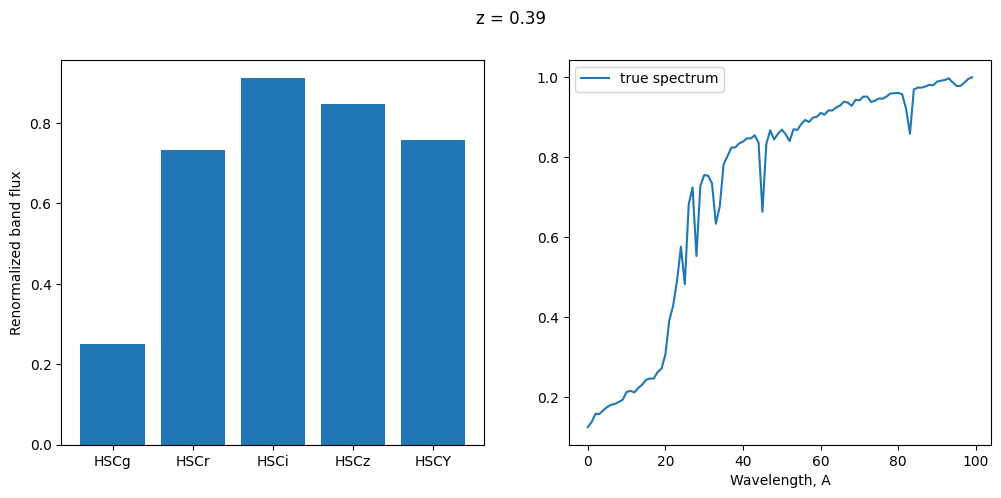

[ 0.39065876  0.07414038 -0.40756762]


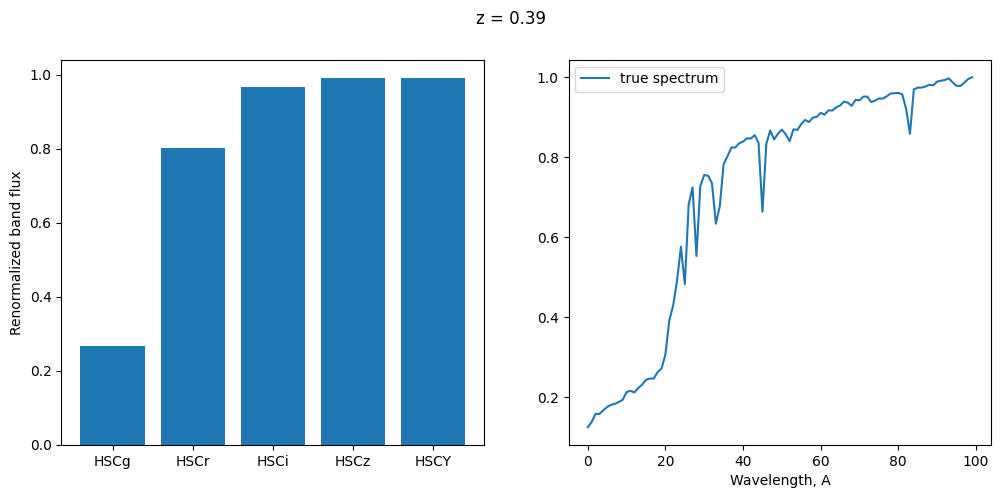

[ 0.39065876  0.07414038 -0.40756762]


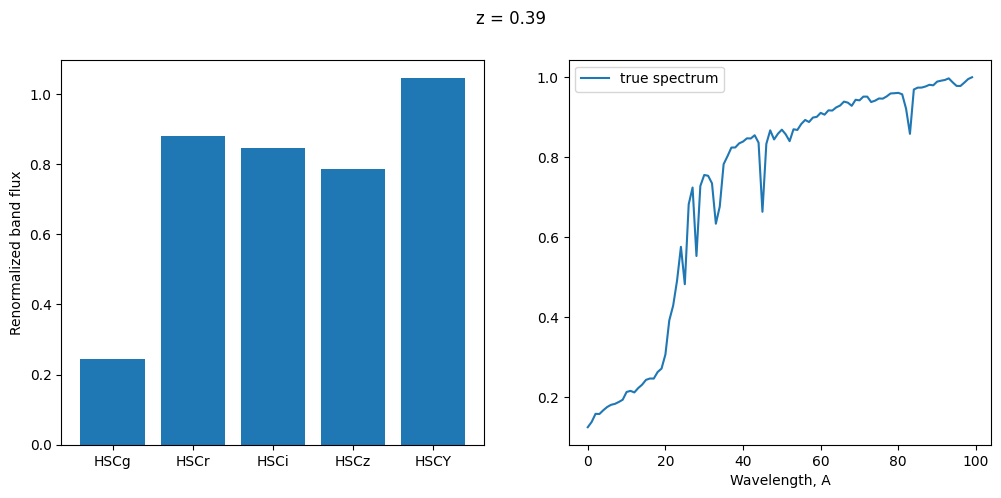

[ 0.39065876  0.07414038 -0.40756762]


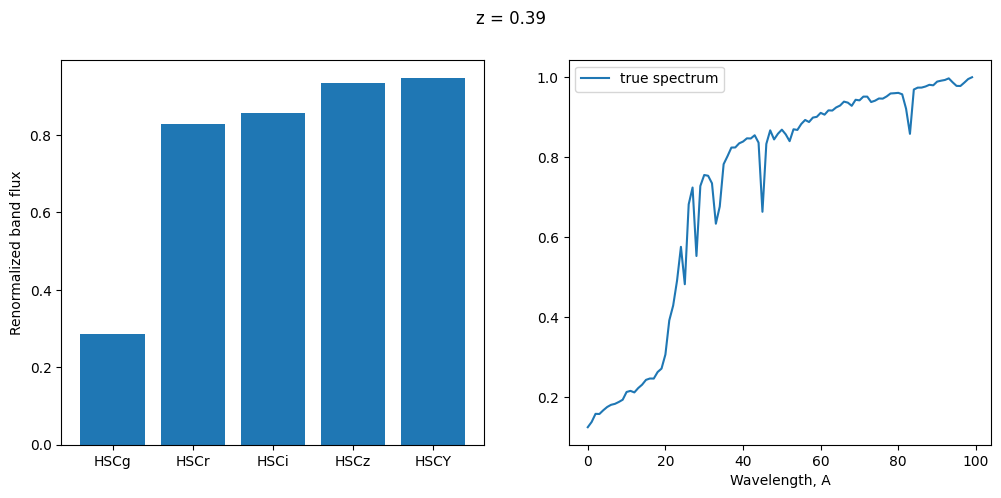

[ 0.39065876  0.07414038 -0.40756762]


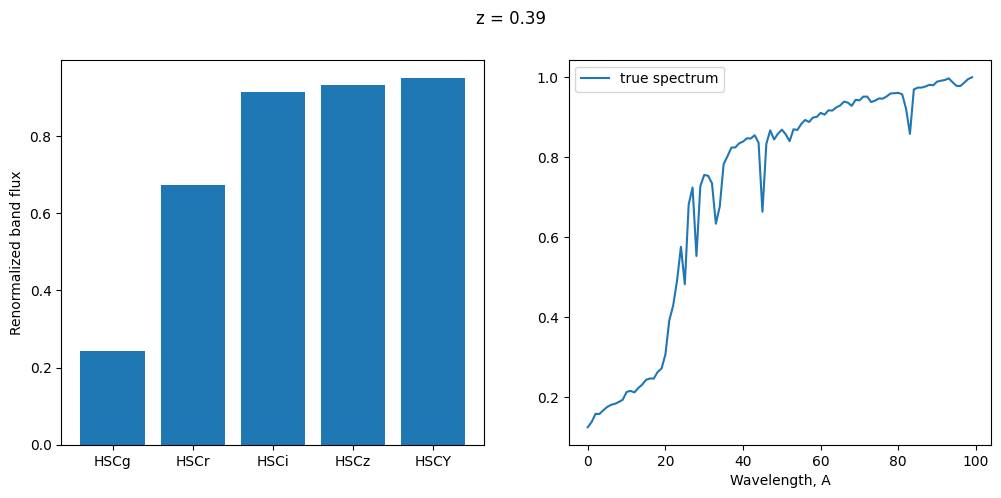

[ 0.39065876  0.07414038 -0.40756762]


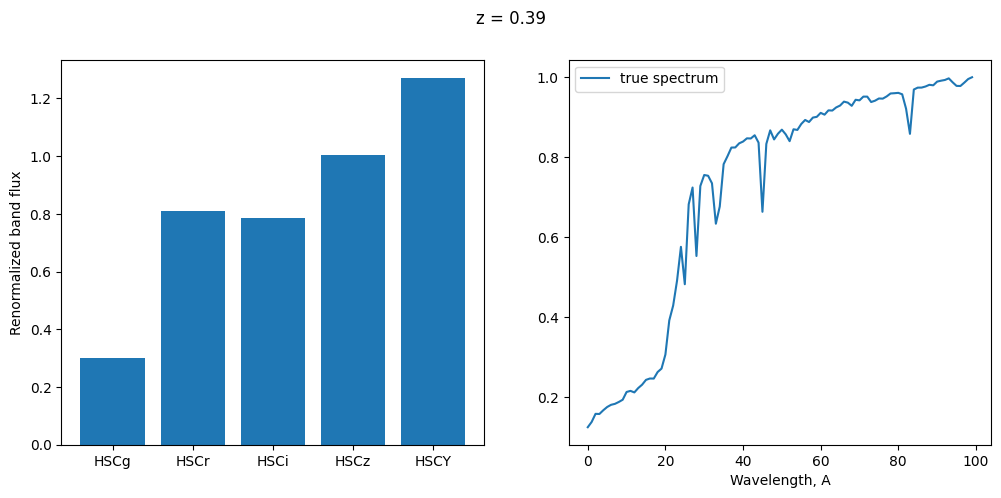

[ 0.39065876  0.07414038 -0.40756762]


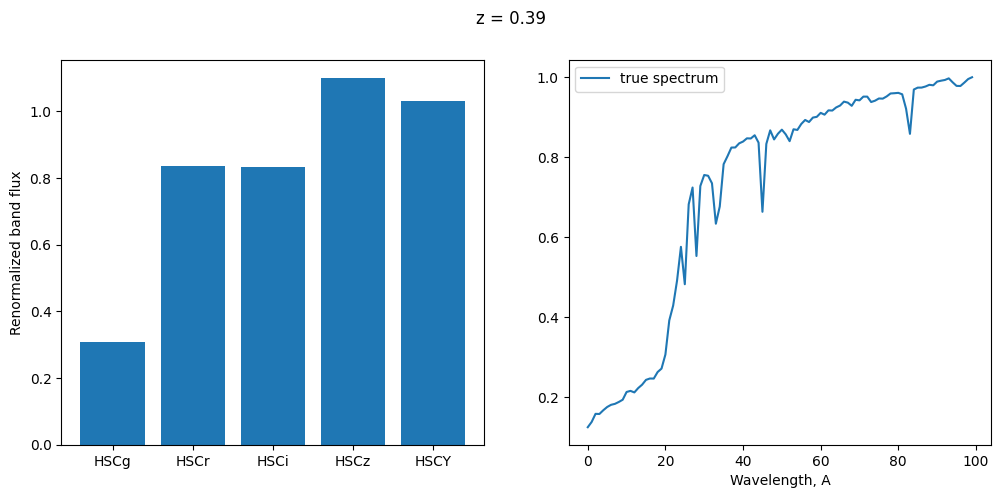

[ 0.39065876  0.07414038 -0.40756762]


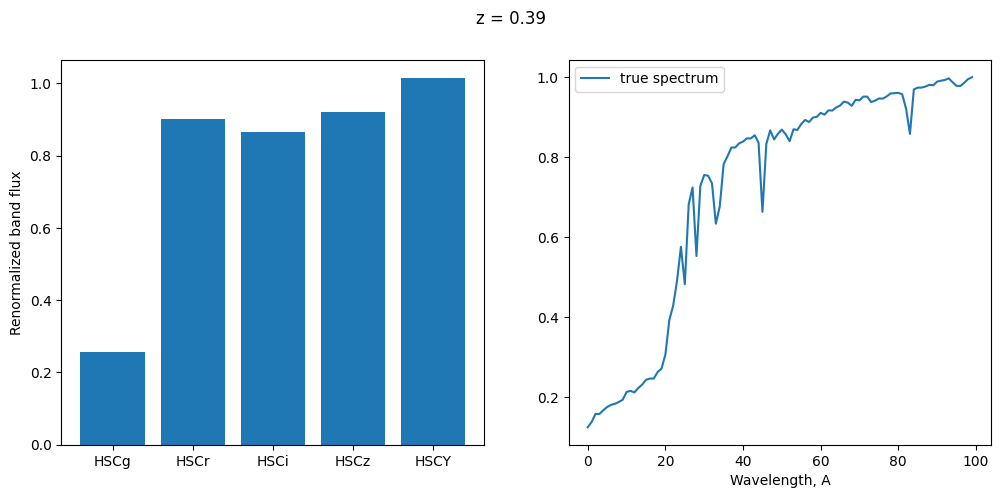

[ 0.39065876  0.07414038 -0.40756762]


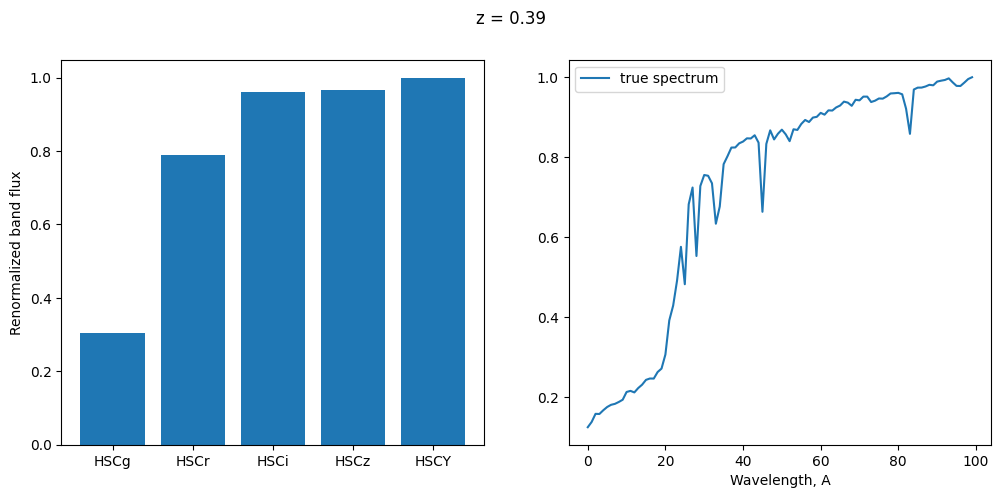

[ 0.39065876  0.07414038 -0.40756762]


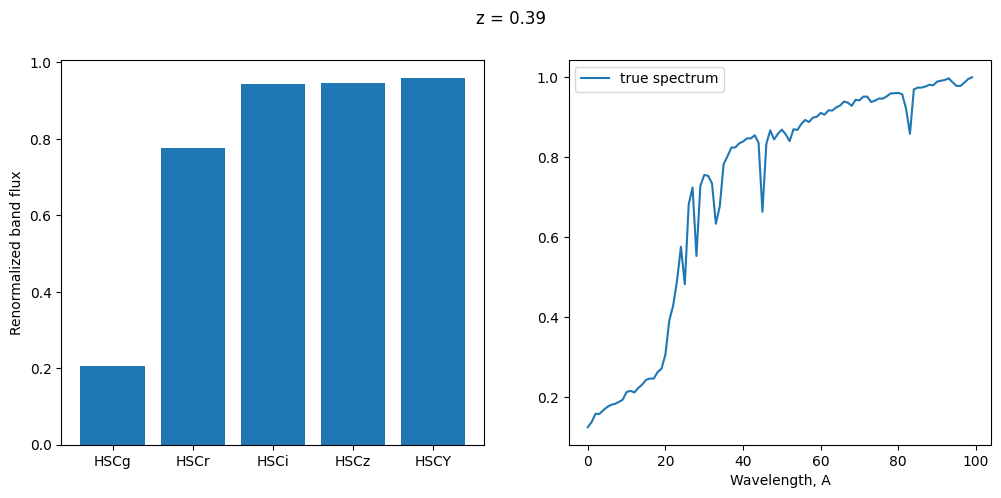

In [185]:
ii=1000
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    print(params[ii])
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()

In [ ]:
spvae = SpectraVAE(100, latent_dim, beta=beta)
spvae.compile(optimizer=keras.optimizers.Adam())
hsp=spvae.fit(spectra, epochs=epochs, batch_size=128, validation_split=0.2)

Epoch 1/50


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_275']
Received: inputs=Tensor(shape=(128, 100))
  warnings.warn(msg)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - kl_loss: 39.8786 - loss: 0.0818 - reconstruction_loss: 0.0699 - val_kl_loss: 29.7023 - val_loss: 0.0319 - val_reconstruction_loss: 0.0230
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - kl_loss: 23.0340 - loss: 0.0248 - reconstruction_loss: 0.0179 - val_kl_loss: 17.0564 - val_loss: 0.0210 - val_reconstruction_loss: 0.0159
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - kl_loss: 14.8358 - loss: 0.0179 - reconstruction_loss: 0.0135 - val_kl_loss: 12.0738 - val_loss: 0.0153 - val_reconstruction_loss: 0.0116
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - kl_loss: 11.5980 - loss: 0.0144 - reconstruction_loss: 0.0110 - val_kl_loss: 10.6098 - val_loss: 0.0133 - val_reconstruction_loss: 0.0101
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - kl_loss: 10.5496 - loss: 0.0127 - reconstruction_loss: 0.0095 - val_kl_loss: 10.2754 - val_loss: 0.0112 - val_reconstruction_loss: 0.0081
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
ii=1126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = spvae(np.reshape(spectra[ii], (1,100)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[0].plot(range(len(spectra[ii])), spectra[ii])
    plt.legend()
    plt.show()

In [ ]:
class BandPassVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='dense_encoder')

        self.decoder = spvae.decoder
        self.decoder.trainable = False  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [ ]:
bpvae = BandPassVAE(5,latent_dim, beta=beta)
bpvae.compile(optimizer=keras.optimizers.Adam())
h=bpvae.fit((integrals, spectra), epochs=epochs, batch_size=128, validation_split=0.2)


In [ ]:
ii=10126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = bpvae(np.reshape(integrals[ii], (1,5)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()

In [ ]:
def build_dense_decoder_param(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


class ParamVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])
        self.wei = np.array([1, 1, 1])
        self.wei = self.wei / np.sum(self.wei)
        self.encoder = bpvae.encoder
        self.encoder.trainable = False  # Prevent training of the decoder

        self.decoder = build_dense_decoder_param(latent_dim,(3,1))
        self.decoder.trainable = True  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.square(data_out*self.wei - reconstruction*self.wei)
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square(data_out*self.wei - reconstruction*self.wei))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [ ]:
parvae = ParamVAE(3,latent_dim, beta=beta)
parvae.compile(optimizer=keras.optimizers.Adam())
h=parvae.fit((integrals, params), epochs=epochs, batch_size=128, validation_split=0.2)

In [ ]:
pnames = ['z', 't', '[Z/H]']

s = parvae(np.reshape(integrals[:80000], (80000,5)))
p = params[:80000]

res = s - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

In [ ]:
plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.hist2d(plx, ply, bins=100)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

In [ ]:
idx_sel = np.where(params[:,0] == params[200000, 0])[0]

for i in range(0, 5):
    plt.hist(integrals[idx_sel][:,i])

plt.xscale('log')
plt.show()

In [ ]:
axs = (1, 1)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

plx = p[:, axs[0]] * 10
ply = res[:, axs[1]] * 10.0
plt.hist2d(plx, ply, bins=16)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

In [ ]:
t_hsc_ = Table.read('DESI_DR1_HSCSSP_clean_RCSED.fits')
     

hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.1) & (t_hsc_['z'] < 0.95) & (t_hsc_['zwarn'] == 0))]

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']

s = parvae(np.reshape(hsc_int[:n], (n,5)))
p = hsz_z[:n]

res = s[:, 0] - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:]
ply = res[:]
plt.hist2d(plx, ply, bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
filename = f"plot_dz_beta{beta}_epochs{epochs}_latent{latent_dim}.png"
filename = os.path.join(fig_path, filename)
plt.savefig(filename)
mlflow.log_artifact(filename, artifact_path="plots")

plx = p[:]
ply = res[:]
plt.hist2d(p[:], s[:, 0], bins=40)
plt.plot([0, 1], [0, 1], color='red')
plt.ylim(np.min(p[:]), np.max(p[:]))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$ ' + pnames[axs[1]] + '$')
filename = f"plot_zz_beta{beta}_epochs{epochs}_latent{latent_dim}.png"
filename = os.path.join(fig_path, filename)
plt.savefig(filename)
mlflow.log_artifact(filename, artifact_path="plots")

t_hsc['z_photo'] = s[:, 0]



In [ ]:
hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.1) & (t_hsc_['z'] < 0.95) & (t_hsc_['zwarn'] == 0))]

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']

s = parvae(np.reshape(hsc_int[:n], (n,5)))
p = hsz_z[:n]

res = s[:, 0] - p
print(s[0], p[0])
axs = (0, 0)


plx = p[:]
ply = res[:]
plt.plot(plx, ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()
t_hsc['z_photo'] = s[:, 0]

In [ ]:
plx = np.array(p[:])
ply = np.array(res[:])
print(plx)
# Set number of bins
N = 20  # You can change this to whatever number of bins you want

# Digitize plx into N bins
bins = np.linspace(np.min(plx), np.max(plx), N + 1)
indices = np.digitize(plx, bins)

# Subtract median ply in each bin
corrected_ply = ply
for i in range(1, N + 1):
    bin_mask = indices == i
    if np.any(bin_mask):
        median_val = np.median(ply[bin_mask])
        corrected_ply[bin_mask] -= median_val

# Plot the corrected data
plt.plot(plx, corrected_ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$ (median subtracted)')
plt.show()

plt.hist2d(plx, ply, bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


from astropy.stats import sigma_clip


N = 20

# Digitize plx into N bins
bins = np.linspace(np.min(plx), np.max(plx), N + 1)
indices = np.digitize(plx, bins)

# Subtract sigma-clipped mean of ply in each bin
corrected_ply = ply.copy()
for i in range(1, N + 1):
    bin_mask = indices == i
    if np.any(bin_mask):
        clipped = sigma_clip(ply[bin_mask], sigma=2.5, maxiters=20)
        mean_val = np.median(clipped.data[~clipped.mask])
        print(np.mean(plx[bin_mask]), mean_val)
        corrected_ply[bin_mask] -= mean_val

# Plot the corrected data
plt.plot(plx, corrected_ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

# 2D histogram
plt.hist2d(plx, corrected_ply, bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.colorbar(label='Counts')
plt.show()


In [ ]:
r = t_hsc[t_hsc['targetid'] == 39627755108697773][0]

ii = 50500

print(r)

mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

print(params[ii])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
#axs[1].plot(wllr, spectra[ii], label="true spectrum")
#s = bpvae(np.reshape(bandfl, (1,5)))
#s = np.reshape(s[0].numpy(),(100,))
#axs[1].plot(wllr, s, label="spectrum from bandpasses")
#axs[1].set_xlabel('Wavelength, A')
axs[0].bar(filer_names, bandfl, fill=False, edgecolor='blue')
axs[0].bar(filer_names, integrals[ii], fill=False, edgecolor='green')
axs[0].set_ylabel('Renormalized band flux')
#fig.suptitle('z = %.2f' % (params[ii, 0]))

s = bpvae(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s)
#plt.legend()
plt.show()

p_ls = parvae.apply(np.reshape(bandfl, (1,5)))


p = parvae(np.reshape(bandfl, (1,5)))

print(p_ls)

param_evals = []

nsmpl = 1000
for i in range(nsmpl):
    p_ls = parvae(np.reshape(bandfl, (1,5)))
    param_evals.append(p_ls[0].numpy())

param_evals = np.array(param_evals)
plt.hist(param_evals[:, 0])
plt.axvline(r['z'])

plt.show()


plt.hist2d(param_evals[:, 0], param_evals[:, 1])
plt.show()

plt.plot(param_evals[:, 0], param_evals[:, 1], 'k+')
plt.show()

In [ ]:
mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

rall = np.sum((integrals - bandfl)**2, axis=-1)

idx = np.where(rall < 5*0.010**2)[0]

p_v = params[idx]

plt.plot(param_evals[:, 0], param_evals[:, 1], 'g.')

plt.plot(p_v[:, 0], p_v[:, 1], 'k+')
plt.axvline(r['z'])
plt.axhline(r['ssp_age']/1e4)

plt.show()

In [ ]:
ii = 5700

bandfl = integrals[ii]

idx_same_smpl = np.where(params == params[ii])[0]
print(idx_same_smpl)


nsmpl = 10
p_est = []
for idx_sm_ in idx_same_smpl:
    for i in range(nsmpl):
        p_estls = parvae(np.reshape(integrals[idx_sm_], (1,5)))
        p_est.append(p_estls[0].numpy())

p_est = np.array(p_est)

p0 = params[ii]

print(p0)


fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
axs[0].bar(filer_names, integrals[ii], fill=False, edgecolor='green')
axs[0].set_ylabel('Renormalized band flux')

s = bpvae(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s)
plt.show()




rall = np.sum((integrals - bandfl)**2, axis=-1)

idx = np.where(rall < 5*0.030**2)[0]


p_v = params[idx]

plt.plot(p_est[:, 0], p_est[:, 1], 'g.')

plt.plot(p_v[:, 0], p_v[:, 1], 'k+')
plt.axvline(p0[0])
plt.axhline(p0[1])

plt.show()

